# Interactive Tabular RL Maze: Q-Learning, SARSA, and Dyna-Q

**New features**
- Switch between **Q-Learning**, **SARSA(0)** (on-policy), and **Dyna-Q** (model-based).
- Choose **Deterministic** vs **Stochastic** dynamics (slip probability).
- Toggle **Dense** vs **Sparse** rewards.
- Option to **keep previous learning curves** when switching agents or resetting.
- Smooth visualization with throttled redraws and artist reuse.

**How to use**
1. Run the cell below.
2. Controls: Algorithm, alpha, gamma, epsilon, planning (for Dyna-Q), stochastic toggle & slip p, reward mode, keep curves, visual FPS & delay, Q stride.
3. Click in the maze to toggle walls; **Shift+Click** to move the goal.

> Requires `%matplotlib widget` (JupyterLab + ipympl). If needed: `pip install ipympl` and restart kernel.


In [2]:
!pip install ipympl

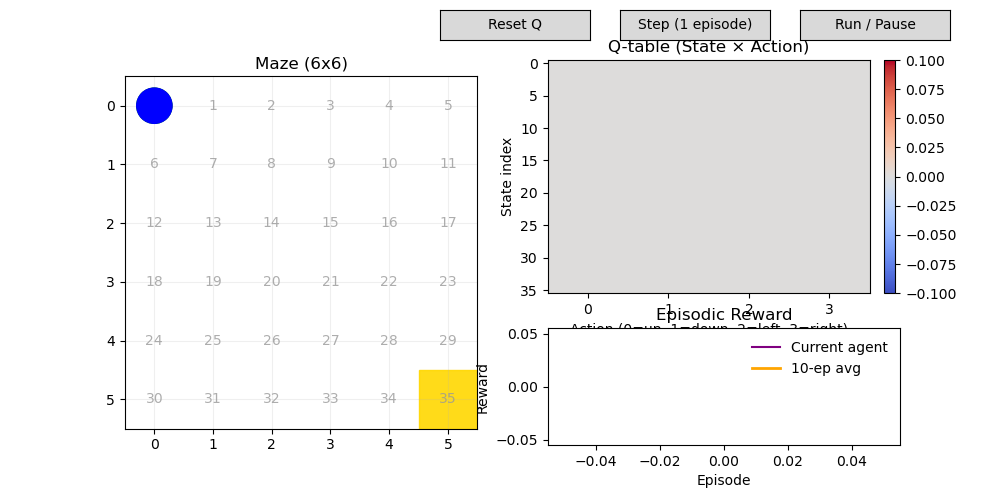

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt


from matplotlib.widgets import Button
import ipywidgets as widgets
from IPython.display import display
import threading, time, random

random.seed(42)

# -----------------------------
# Environment
# -----------------------------
class MazeEnv:
    def __init__(self, h=6, w=6, start=(0,0), goal=(5,5), stochastic=False, slip_prob=0.2, reward_scheme='dense'):
        self.h, self.w = h, w
        self.start, self.goal = start, goal
        self.walls = set()
        self.stochastic = stochastic
        self.slip_prob = slip_prob
        self.reward_scheme = reward_scheme  # 'dense' or 'sparse'
        self.reset()

    def reset(self):
        self.agent = self.start
        return self.agent

    def index_state(self, idx):
        return (idx // self.w, idx % self.w)

    def state_index(self, state):
        return state[0] * self.w + state[1]

    def _maybe_slip(self, action):
        if not self.stochastic:
            return action
        if np.random.rand() < self.slip_prob:
            return np.random.randint(4)
        return action

    def _step_reward(self, done):
        if done:
            return 1.0
        # dense vs sparse
        return -0.01 if self.reward_scheme == 'dense' else 0.0

    def step(self, action):
        a = self._maybe_slip(action)
        i, j = self.agent
        if a == 0:      # up
            i = max(i-1, 0)
        elif a == 1:    # down
            i = min(i+1, self.h-1)
        elif a == 2:    # left
            j = max(j-1, 0)
        elif a == 3:    # right
            j = min(j+1, self.w-1)
        if (i, j) in self.walls:
            i, j = self.agent
        self.agent = (i, j)
        done = (self.agent == self.goal)
        reward = self._step_reward(done)
        return self.agent, reward, done

# -----------------------------
# Tabular Agents: Q-Learning, SARSA(0), Dyna-Q
# -----------------------------
class QBase:
    def __init__(self, env, alpha=0.1, gamma=0.95, eps=0.2):
        self.env = env
        self.alpha, self.gamma, self.eps = float(alpha), float(gamma), float(eps)
        self.q = np.zeros((env.h * env.w, 4), dtype=np.float32)
    def set_params(self, alpha=None, gamma=None, eps=None):
        if alpha is not None: self.alpha = float(alpha)
        if gamma is not None: self.gamma = float(gamma)
        if eps is not None:   self.eps   = float(eps)
    def policy(self, state):
        s = self.env.state_index(state)
        if np.random.rand() < self.eps:
            return np.random.randint(4)
        row = self.q[s]
        maxv = np.max(row); best = np.flatnonzero(row == maxv)
        return int(np.random.choice(best))

class QLearner(QBase):
    def update(self, s, a, r, s_next, done):
        si, sj = self.env.state_index(s), self.env.state_index(s_next)
        best_next = np.max(self.q[sj])
        td_target = r + self.gamma * best_next * (1 - int(done))
        self.q[si, a] += self.alpha * (td_target - self.q[si, a])

class SARSALearner(QBase):
    def update_sarsa(self, s, a, r, s_next, a_next, done):
        si, sj = self.env.state_index(s), self.env.state_index(s_next)
        next_q = self.q[sj, a_next] if not done else 0.0
        td_target = r + self.gamma * next_q
        self.q[si, a] += self.alpha * (td_target - self.q[si, a])

class DynaQAgent(QLearner):
    def __init__(self, env, alpha=0.1, gamma=0.95, eps=0.2, n_planning=20):
        super().__init__(env, alpha, gamma, eps)
        self.n_planning = int(n_planning)
        self.model = {}  # (si,a) -> (sj, r)
    def set_planning(self, n_planning):
        self.n_planning = int(n_planning)
    def update(self, s, a, r, s_next, done):
        super().update(s, a, r, s_next, done)
        si = self.env.state_index(s); sj = self.env.state_index(s_next)
        self.model[(si, a)] = (sj, r)
        if self.n_planning <= 0 or not self.model:
            return
        keys = list(self.model.keys())
        for _ in range(self.n_planning):
            msi, ma = keys[np.random.randint(len(keys))]
            msj, mr = self.model[(msi, ma)]
            s_next_state = self.env.index_state(msj)
            m_done = (s_next_state == self.env.goal)
            best_next = np.max(self.q[msj])
            td_target = mr + self.gamma * best_next * (1 - int(m_done))
            self.q[msi, ma] += self.alpha * (td_target - self.q[msi, ma])

# -----------------------------
# Interactive Trainer (optimized)
# -----------------------------
class InteractiveTrainer:
    def __init__(self, env, agent, max_fps=10, q_update_stride=5, visual_delay=0.03):
        self.env, self.agent = env, agent
        self.running = False
        self.stop_event = threading.Event()
        self.training_thread = None
        self.rewards = []
        self.archived_rewards = []  # previous curves
        self.cbar = None
        self.q_update_stride = q_update_stride
        self.max_fps = max_fps
        self.visual_delay = visual_delay
        self._last_draw = 0.0
        self.step_counter = 0

        # Figure & axes
        self.fig = plt.figure(figsize=(10, 5))
        gs = self.fig.add_gridspec(2, 2, height_ratios=[2, 1])
        self.ax_maze = self.fig.add_subplot(gs[:, 0])
        self.ax_q = self.fig.add_subplot(gs[0, 1])
        self.ax_reward = self.fig.add_subplot(gs[1, 1])

        # Buttons
        ax_run = plt.axes([0.80, 0.92, 0.15, 0.06])
        self.btn_run = Button(ax_run, 'Run / Pause')
        self.btn_run.on_clicked(self.toggle_run)
        ax_step = plt.axes([0.62, 0.92, 0.15, 0.06])
        self.btn_step = Button(ax_step, 'Step (1 episode)')
        self.btn_step.on_clicked(lambda event: self.run_episode())
        ax_resetq = plt.axes([0.44, 0.92, 0.15, 0.06])
        self.btn_resetq = Button(ax_resetq, 'Reset Q')
        self.btn_resetq.on_clicked(self.reset_q)

        # Mouse interaction
        self.cid_click = self.fig.canvas.mpl_connect('button_press_event', self.on_click)

        # --- Controls (widgets) ---
        self.algo_dropdown = widgets.Dropdown(options=['Q-Learning', 'SARSA', 'Dyna-Q'], value='Q-Learning', description='Algorithm:')
        self.alpha_slider = widgets.FloatSlider(value=self.agent.alpha, min=0.0, max=1.0, step=0.01, description='alpha:')
        self.gamma_slider = widgets.FloatSlider(value=self.agent.gamma, min=0.0, max=0.999, step=0.01, description='gamma:')
        self.eps_slider   = widgets.FloatSlider(value=self.agent.eps,   min=0.0, max=1.0, step=0.01, description='epsilon:')
        self.plan_slider  = widgets.IntSlider(value=20, min=0, max=100, step=1, description='planning:')
        self.stoch_toggle = widgets.Checkbox(value=self.env.stochastic, description='Stochastic env')
        self.slip_slider  = widgets.FloatSlider(value=self.env.slip_prob, min=0.0, max=1.0, step=0.05, description='slip p:')
        self.rewards_mode = widgets.Dropdown(options=['Dense (-0.01/step)','Sparse (0/step)'], value=('Dense (-0.01/step)' if self.env.reward_scheme=='dense' else 'Sparse (0/step)'), description='Rewards:')
        self.keep_curves_chk = widgets.Checkbox(value=True, description='Keep previous curves')
        self.speed_slider = widgets.FloatSlider(value=self.visual_delay, min=0.0, max=0.2, step=0.005, description='Delay (s):', readout_format='.3f')
        self.fps_slider   = widgets.IntSlider(value=self.max_fps, min=1, max=30, step=1, description='FPS:')
        self.qstride_slider = widgets.IntSlider(value=self.q_update_stride, min=1, max=50, step=1, description='Q stride:')
        self.clear_curves_btn = widgets.Button(description='Clear curves', button_style='')

        # Observers
        def _on_algo(change):
            if change['name'] != 'value': return
            self.switch_algorithm(change['new'])
        def _on_alpha(change):
            if change['name'] != 'value': return
            self.agent.set_params(alpha=change['new'])
        def _on_gamma(change):
            if change['name'] != 'value': return
            self.agent.set_params(gamma=change['new'])
        def _on_eps(change):
            if change['name'] != 'value': return
            self.agent.set_params(eps=change['new'])
        def _on_plan(change):
            if change['name'] != 'value': return
            if isinstance(self.agent, DynaQAgent):
                self.agent.set_planning(change['new'])
        def _on_stoch(change):
            if change['name'] != 'value': return
            self.env.stochastic = bool(change['new'])
        def _on_slip(change):
            if change['name'] != 'value': return
            self.env.slip_prob = float(change['new'])
        def _on_rewards(change):
            if change['name'] != 'value': return
            self.env.reward_scheme = 'dense' if 'Dense' in change['new'] else 'sparse'
        def _on_speed(change):
            if change['name'] != 'value': return
            self.visual_delay = float(change['new'])
        def _on_fps(change):
            if change['name'] != 'value': return
            self.max_fps = int(change['new'])
        def _on_qstride(change):
            if change['name'] != 'value': return
            self.q_update_stride = int(change['new'])
        def _on_clear_curves(btn):
            self.archived_rewards.clear(); self._update_reward_artists(force_axes=True)

        self.algo_dropdown.observe(_on_algo, names='value')
        self.alpha_slider.observe(_on_alpha, names='value')
        self.gamma_slider.observe(_on_gamma, names='value')
        self.eps_slider.observe(_on_eps, names='value')
        self.plan_slider.observe(_on_plan, names='value')
        self.stoch_toggle.observe(_on_stoch, names='value')
        self.slip_slider.observe(_on_slip, names='value')
        self.rewards_mode.observe(_on_rewards, names='value')
        self.speed_slider.observe(_on_speed, names='value')
        self.fps_slider.observe(_on_fps, names='value')
        self.qstride_slider.observe(_on_qstride, names='value')
        self.clear_curves_btn.on_click(_on_clear_curves)

        display(widgets.VBox([
            widgets.HBox([self.algo_dropdown, self.alpha_slider, self.gamma_slider, self.eps_slider, self.plan_slider]),
            widgets.HBox([self.stoch_toggle, self.slip_slider, self.rewards_mode, self.keep_curves_chk, self.clear_curves_btn]),
            widgets.HBox([self.speed_slider, self.fps_slider, self.qstride_slider])
        ]))

        # Build artists once
        self._init_maze_artists()
        self._init_q_artists()
        self.reward_line, = self.ax_reward.plot([], [], color='purple', lw=1.5, label='Current agent')
        self.avg_line, = self.ax_reward.plot([], [], color='orange', lw=2, label='10-ep avg')
        self.ax_reward.set_title('Episodic Reward')
        self.ax_reward.set_xlabel('Episode')
        self.ax_reward.set_ylabel('Reward')
        self.ax_reward.legend(loc='best', frameon=False)
        self.fig.canvas.draw_idle()

    # ---------- Algorithm switching ----------
    def switch_algorithm(self, algo_name):
        self.pause_training()
        # Archive current curve if requested
        if self.keep_curves_chk.value and len(self.rewards) > 0:
            self.archived_rewards.append(self.rewards.copy())
        old_q = self.agent.q.copy()
        # Create new agent of requested type (preserve params and Q-table)
        if algo_name == 'Dyna-Q' and not isinstance(self.agent, DynaQAgent):
            new_agent = DynaQAgent(self.env, alpha=self.agent.alpha, gamma=self.agent.gamma, eps=self.agent.eps, n_planning=self.plan_slider.value)
        elif algo_name == 'SARSA' and not isinstance(self.agent, SARSALearner):
            new_agent = SARSALearner(self.env, alpha=self.agent.alpha, gamma=self.agent.gamma, eps=self.agent.eps)
        elif algo_name == 'Q-Learning' and not isinstance(self.agent, QLearner):
            new_agent = QLearner(self.env, alpha=self.agent.alpha, gamma=self.agent.gamma, eps=self.agent.eps)
        else:
            return  # no change
        new_agent.q = old_q
        self.agent = new_agent
        # Reset current rewards for new curve
        self.rewards = []
        self.step_counter = 0
        self._update_reward_artists(force_axes=True)
        self._update_q_artist(force=True)
        self.fig.canvas.draw_idle()

    # ---------- Init / Artists ----------
    def _init_maze_artists(self):
        ax = self.ax_maze
        ax.set_title('Maze (6x6)')
        ax.set_xlim(-0.5, self.env.w - 0.5)
        ax.set_ylim(-0.5, self.env.h - 0.5)
        ax.set_xticks(range(self.env.w))
        ax.set_yticks(range(self.env.h))
        ax.grid(True, alpha=0.2)
        ax.invert_yaxis()
        # Walls as image
        self.wall_grid = np.zeros((self.env.h, self.env.w), dtype=np.uint8)
        self.wall_img = ax.imshow(self.wall_grid, cmap='gray_r', vmin=0, vmax=1,
                                  extent=[-0.5, self.env.w-0.5, self.env.h-0.5, -0.5],
                                  interpolation='nearest', alpha=1.0)
        # Goal
        gi, gj = self.env.goal
        self.goal_rect = plt.Rectangle((gj - 0.5, gi - 0.5), 1, 1, color='gold', alpha=0.9)
        ax.add_patch(self.goal_rect)
        # Start & agent
        si, sj = self.env.start
        self.start_circle = plt.Circle((sj, si), 0.3, color='green', zorder=3)
        ax.add_patch(self.start_circle)
        ai, aj = self.env.agent
        self.agent_circle = plt.Circle((aj, ai), 0.3, color='blue', zorder=3)
        ax.add_patch(self.agent_circle)

         # --- NEW: state labels (row-major state index) ---    
        self.state_labels = []    
        for i in range(self.env.h):       
            for j in range(self.env.w):            
                s_idx = i * self.env.w + j            
                # Center of the cell is at (x=j, y=i)            
                txt = ax.text(                
                    j, i, str(s_idx),                
                    ha='center', va='center',                
                    color='#999999',  # light gray                
                    alpha=0.8,                
                    zorder=2          # under agent/start, over wall image            
                )  
                
        self._sync_walls_to_image()

    def _init_q_artists(self):
        self.ax_q.set_title('Q-table (State × Action)')
        self.q_img = self.ax_q.imshow(self.agent.q, aspect='auto', cmap='coolwarm', origin='upper')
        self.ax_q.set_xlabel('Action (0=up, 1=down, 2=left, 3=right)')
        self.ax_q.set_ylabel('State index')
        self.cbar = self.fig.colorbar(self.q_img, ax=self.ax_q, fraction=0.046, pad=0.04)

    # ---------- Control ----------
    def reset_q(self, event=None):
        self.pause_training()
        if self.keep_curves_chk.value and len(self.rewards) > 0:
            self.archived_rewards.append(self.rewards.copy())
        self.agent.q[:] = 0.0
        self.rewards = []
        self.step_counter = 0
        self._update_reward_artists(force_axes=True)
        self._update_q_artist(force=True)
        self.fig.canvas.draw_idle()

    def toggle_run(self, event=None):
        if not self.running:
            self.running = True
            self.stop_event.clear()
            self.training_thread = threading.Thread(target=self.training_loop, daemon=True)
            self.training_thread.start()
        else:
            self.pause_training()

    def pause_training(self):
        if self.running:
            self.running = False
            self.stop_event.set()
            if self.training_thread is not None and self.training_thread.is_alive():
                self.training_thread.join(timeout=0.5)
            self.training_thread = None
            self.stop_event.clear()

    # ---------- Mouse ----------
    def on_click(self, event):
        if event.inaxes is not self.ax_maze:
            return
        if event.xdata is None or event.ydata is None:
            return
        i = int(round(event.ydata)); j = int(round(event.xdata))
        i = max(0, min(self.env.h - 1, i))
        j = max(0, min(self.env.w - 1, j))
        if 'shift' in (event.key or '').lower():
            if (i, j) != self.env.start:
                self.env.goal = (i, j)
                if (i, j) in self.env.walls:
                    self.env.walls.remove((i, j))
                self._move_goal(i, j)
        else:
            if (i, j) in self.env.walls:
                self.env.walls.remove((i, j))
            elif (i, j) != self.env.start and (i, j) != self.env.goal:
                self.env.walls.add((i, j))
            self._sync_walls_to_image()
        self.pause_training()
        self.fig.canvas.draw_idle()

    # ---------- Training ----------
    def training_loop(self):
        while not self.stop_event.is_set():
            self.run_episode()
            time.sleep(0.01)

    def run_episode(self, max_steps=150):
        total_reward = 0.0
        s = self.env.reset()
        self._move_agent(*s, draw_now=True)
        done, steps = False, 0
        # Algorithm-specific stepping
        if isinstance(self.agent, SARSALearner):
            a = self.agent.policy(s)
            while not done and steps < max_steps and not self.stop_event.is_set():
                s_next, r, done = self.env.step(a)
                a_next = self.agent.policy(s_next) if not done else 0
                self.agent.update_sarsa(s, a, r, s_next, a_next, done)
                s, a = s_next, a_next
                total_reward += r
                steps += 1; self.step_counter += 1
                self._move_agent(*s)
                if self.step_counter % self.q_update_stride == 0:
                    self._update_q_artist()
        else:
            while not done and steps < max_steps and not self.stop_event.is_set():
                a = self.agent.policy(s)
                s_next, r, done = self.env.step(a)
                self.agent.update(s, a, r, s_next, done)
                s = s_next
                total_reward += r
                steps += 1; self.step_counter += 1
                self._move_agent(*s)
                if self.step_counter % self.q_update_stride == 0:
                    self._update_q_artist()
        self.rewards.append(total_reward)
        self._update_reward_artists()
        self._draw_if_due(force=True)

    # ---------- Artist updates ----------
    def _move_agent(self, i, j, draw_now=False):
        self.agent_circle.center = (j, i)
        self._draw_if_due(force=draw_now)
    def _move_goal(self, i, j):
        self.goal_rect.set_xy((j - 0.5, i - 0.5))
    def _sync_walls_to_image(self):
        self.wall_grid[:, :] = 0
        for (wi, wj) in self.env.walls:
            self.wall_grid[wi, wj] = 1
        self.wall_img.set_data(self.wall_grid)
    def _update_q_artist(self, force=False):
        self.q_img.set_data(self.agent.q)
        if force:
            vmin, vmax = float(np.min(self.agent.q)), float(np.max(self.agent.q))
            if vmax > vmin:
                self.q_img.set_clim(vmin, vmax)
        self._draw_if_due(force=force)
    def _update_reward_artists(self, force_axes=False):
        # Plot archived curves in light gray
        self.ax_reward.clear()
        self.ax_reward.set_title('Episodic Reward')
        self.ax_reward.set_xlabel('Episode')
        self.ax_reward.set_ylabel('Reward')
        for hist in self.archived_rewards:
            xh = np.arange(len(hist))
            self.ax_reward.plot(xh, hist, color='#bbbbbb', lw=1.0, alpha=0.9)
        x = np.arange(len(self.rewards))
        self.reward_line, = self.ax_reward.plot(x, np.array(self.rewards), color='purple', lw=1.5, label='Current agent')
        if len(self.rewards) >= 10:
            window = 10
            avg = np.convolve(self.rewards, np.ones(window)/window, mode='valid')
            xavg = np.arange(window-1, window-1+len(avg))
            self.avg_line, = self.ax_reward.plot(xavg, avg, color='orange', lw=2, label='10-ep avg')
        else:
            self.avg_line, = self.ax_reward.plot([], [], color='orange', lw=2, label='10-ep avg')
        self.ax_reward.legend(loc='best', frameon=False)
        if force_axes:
            self.ax_reward.relim(); self.ax_reward.autoscale_view()

    # ---------- Draw throttling ----------
    def _draw_if_due(self, force=False):
        now = time.time(); min_dt = 1.0 / float(self.max_fps)
        if force or (now - self._last_draw) >= min_dt:
            self.fig.canvas.draw_idle()
            if self.visual_delay > 0:
                time.sleep(self.visual_delay)
            self._last_draw = now

# -----------------------------
# Launch
# -----------------------------
env = MazeEnv(stochastic=False, slip_prob=0.2, reward_scheme='dense')
agent = QLearner(env, alpha=0.1, gamma=0.95, eps=0.2)
trainer = InteractiveTrainer(env, agent, max_fps=10, q_update_stride=5, visual_delay=0.03)
plt.show()


### Notes
- **Rewards:** Dense = small step penalty (-0.01) until goal (+1). Sparse = 0 until goal (+1).
- **SARSA(0):** On-policy update uses the next action chosen from the same epsilon-greedy policy.
- **Dyna-Q:** Stores a simple (state, action)→(next_state, reward) model and performs `planning` updates after each real step.
- **Keep curves:** When toggled, switching algorithms or resetting Q will **archive** the current reward curve in light gray, so you can compare learning runs.
